In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

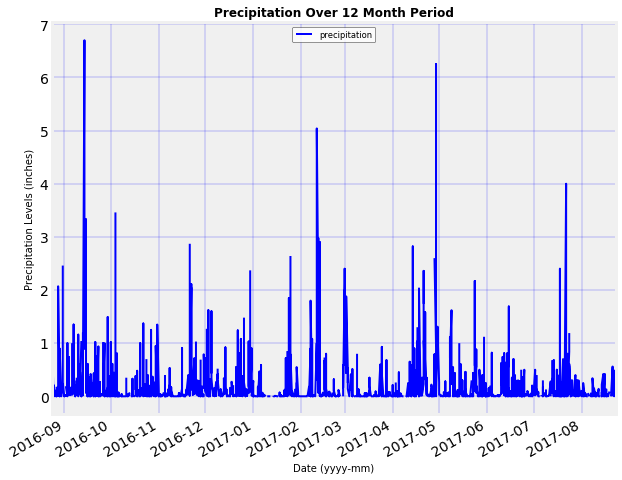

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Get the first element of the tuple
max_date = max_date[0]

# Calculate the date 1 year ago from the last data point in the database
year_from_last_point = dt.datetime.strptime(max_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_from_last_point).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(query,columns=['date', 'precipitation'])
precipitation_xx = pd.DataFrame(query,columns=['date', 'precipitation'])

#Change datatype from element to datetime object on Pandas
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'], format = '%Y-%m-%d')

#Set index to date
precipitation_df.set_index('date', inplace = True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by = 'date',ascending = True)

# Use Pandas Plotting with Matplotlib to plot the data
plot = precipitation_df .plot(kind = 'line', figsize=(9,8), grid = True, fontsize = 14, linewidth = 2, color = 'blue')
plot.figure.set_edgecolor('k')
plot.set_title('Precipitation Over 12 Month Period', fontsize = 12, weight = 'bold')
plot.set_ylabel('Precipitation Levels (inches)', fontsize = 10)
plot.grid(color = 'b', linestyle = '-', linewidth = .25)
plot.set_xlabel('Date (yyyy-mm)', fontsize = 10)
plot.figure.tight_layout = True
plt.legend(loc = 9, fontsize ='small', facecolor = 'white', edgecolor='k')

#Save picture and show fig
plt.savefig("images/Precipitation.png")
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
available_stations = session.query(Measurement.station).distinct().count()
print(f"Stations Available: {available_stations} ")

Stations Available: 9 


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

print("Most Active Stations:")
active_stations

Most Active Stations:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

# Finding most active station 
most_active_station = active_stations[0][0]

most_active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()

print(f"Most Active Station Temperatures in Fahrenheit:")
print(f"Low: {most_active_temps[0][0]} High: {most_active_temps[0][1]} Average: {round(most_active_temps[0][2], 1)}")

Most Active Station Temperatures in Fahrenheit:
Low: 54.0 High: 85.0 Average: 71.7


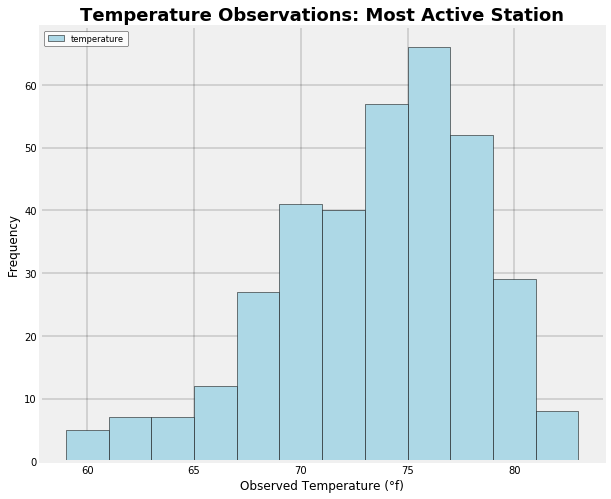

In [62]:
# Choose the station with the highest number of temperature observations.
most_temps_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_temps_station = most_temps_station[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_observations = session.query( Measurement.tobs).filter(Measurement.date >= year_from_last_point).filter(Measurement.station == most_temps_station).all()
temperature_observations = pd.DataFrame(temperature_observations, columns = ['temperature'])

# We need 12 bins since the observation is for twelve months
hist = temperature_observations.plot.hist(bins = 12, figsize = (9,8), edgecolor = 'k', color = 'lightblue', fontsize = 10)

#Set histogram properties for axis lables, legend, and title
hist.figure.set_edgecolor('k')
hist.set_title('Temperature Observations: Most Active Station', fontsize = 18, weight = 'bold')
hist.set_ylabel('Frequency', fontsize = 12)
hist.grid(color = 'k', linestyle = '-', linewidth = .25)
hist.set_xlabel('Observed Temperature (°f)', fontsize = 12)
hist.legend(loc = 2, fontsize = 'small', facecolor = 'white', edgecolor = 'k')

#Save picture and show fig
plt.savefig("images/Temperature Observations: Most Active Station.png")
plt.show()

In [63]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


Min     62.0
Name: tmin, dtype: float64, Avg     69.571429
Name: tavg, dtype: float64, Max     74.0
Name: tmax, dtype: float64


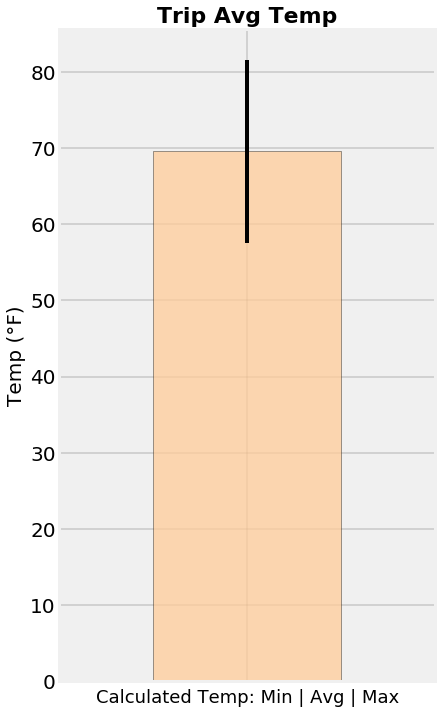

In [64]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

def calc_temps_x(start, end):
    """TMIN, TAVG, and TMAX for a list of dates.

    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
        Returns:
            Bar chart

    """
    
    #Query data based on function input
    query = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date>=start, Measurement.date<=end).all()
    
    # Create a dataframe with the calculated tmin, tavg, and tmax values
    trip_df = pd.DataFrame(query, columns=['tmin', 'tavg', 'tmax'], index=[''])
    TAVG = trip_df['tavg']
    TMIN = trip_df['tmin']
    TMAX = trip_df['tmax']
    
    # Use the average temperature for the y value
    # Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
    fig, ax = plt.subplots(1,1)
    trip_df.plot.bar(y = 'tavg', yerr = (TMAX-TMIN), ax = ax, edgecolor = 'black', color = "#FFCC99", alpha = 0.75,
                     figsize = (6,12), fontsize = 12, ecolor= 'black')
    
    #Set properties for axis lables
    ax.set_ylabel('Temp (°F)', fontsize = 20)
    ax.set_xlabel('Calculated Temp: Min | Avg | Max', fontsize = 18)
    
    # Use "Trip Avg Temp" as your Title
    ax.set_title('Trip Avg Temp', weight = 'bold', fontsize = 22)
    ax.grid(color = 'black', linestyle = '-', linewidth = .25)
    ax.yaxis.set_tick_params(labelsize = 20)
    ax.xaxis.set_tick_params(rotation = 'auto')
    
    plt.gca().legend_.remove()
    return print('Min %s, Avg %s, Max %s' % (TMIN, TAVG, TMAX)), fig, ax

x, y, z = calc_temps_x('2012-02-28', '2012-03-05')
y.savefig("images/Trip Avg Temp.png")


In [71]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def precipitation(start_date, end_date):
    
    # Docstring for the function `calc_temps`
    """Precipitation information per weather station
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of tuples, based on month and day, containing precipitation amount, station, name, latitude, longitude, and elevation.
    """
    
    flex_start_period = start_date[-5:]
    flex_end_period = end_date[-5:]
    ref_year_start = str(int(start_date[0:4]))
    ref_year_end = str(int(start_date[0:4]))
    
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation,
           Measurement.date,
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date>=f'{ref_year_start}-{flex_start_period}').filter(Measurement.date<=f'{ref_year_end}-{flex_end_period}').group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

pd.DataFrame(precipitation('2017-06-22','2018-06-22'))


,station,name,latitude,longitude,elevation,date,prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2017-06-22,0.28
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2017-06-22,0.10
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2017-06-22,0.06
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,2017-06-22,0.00
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2017-06-22,0.00
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2017-06-22,0.00


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


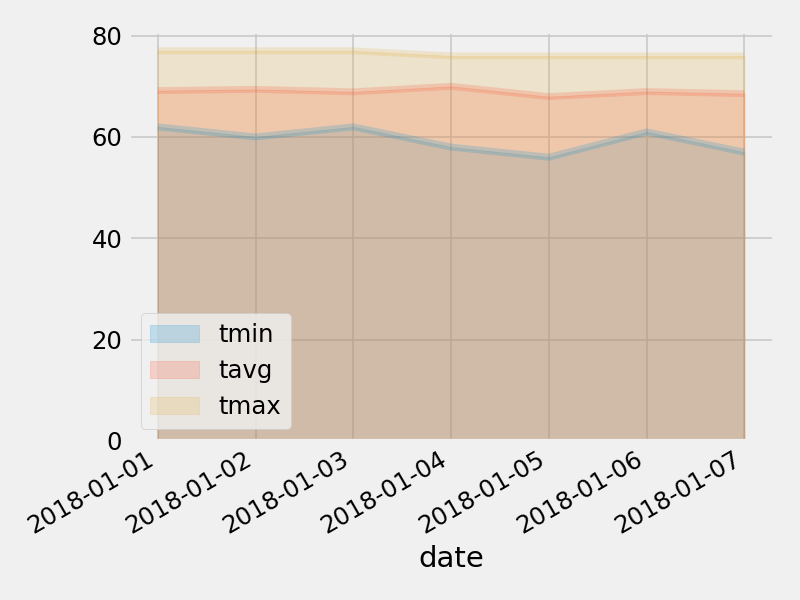

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
